#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

Multiple instances, X pst, 3 or 4 enzymes, one sample and pst per instance, multiple enzymes per instance, test how many psts feasible, how computing time depends on number of enzymes, how computing time depends on N p::f for 60 samples and X psts

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [17]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [4]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['p_occupancy']

,phosphosite,sample,value,prob
0,p0,s1,dec,0.751050
1,p0,s10,dec,0.884666
2,p0,s100,inc,0.885386
3,p0,s11,inc,0.707411
4,p0,s12,dec,0.851823
...,...,...,...,...
95,p0,s95,dec,0.714859
96,p0,s96,dec,0.549454
97,p0,s97,dec,0.840331
98,p0,s98,inc,0.700061


In [15]:
# duplicate data['p_occupancy'] * n and replace p0 in the new df with pn
# use pd.concat
n = 20
new_occ = data['p_occupancy'].copy()
for i in range(1, n):
    new_phos = data['p_occupancy'].copy()
    new_phos['phosphosite'] = new_phos['phosphosite'].replace('p0', 'p' + str(i))
    new_occ = pd.concat([new_occ, new_phos], ignore_index=True)
new_occ

,phosphosite,sample,value,prob
0,p0,s1,dec,0.751050
1,p0,s10,dec,0.884666
2,p0,s100,inc,0.885386
3,p0,s11,inc,0.707411
4,p0,s12,dec,0.851823
...,...,...,...,...
1995,p19,s95,dec,0.714859
1996,p19,s96,dec,0.549454
1997,p19,s97,dec,0.840331
1998,p19,s98,inc,0.700061


In [16]:
# duplicate data['e_activity'] * n and replace e1 in the new df with en
# use pd.concat
n = 2
new_act = data['e_activity'].copy()
for i in range(1, n):
    new_enz = data['e_activity'].loc[data['e_activity']['enzyme'] == f'e1'].copy()
    new_enz['enzyme'] = new_enz['enzyme'].replace('e1', 'e' + str(i+3))
    new_act = pd.concat([new_act, new_enz], ignore_index=True)
new_act

,enzyme,sample,value,prob
0,e1,s1,inc,0.667479
1,e1,s10,dec,0.869338
2,e1,s100,inc,0.962838
3,e1,s11,base,0.883589
4,e1,s12,dec,0.708652
...,...,...,...,...
395,e4,s95,dec,0.917158
396,e4,s96,base,0.830064
397,e4,s97,dec,0.586687
398,e4,s98,inc,0.852893


Splitting data into training/testing

In [17]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.6))
print(train)
# train = ['s1', 's2', 's3']
# filter data
training_data = {}
training_data['e_activity'] = new_act[new_act['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = new_occ[new_occ['sample'].isin(train)].reset_index(drop=True)

['s34', 's33', 's72', 's79', 's77', 's75', 's99', 's2', 's5', 's44', 's89', 's28', 's100', 's16', 's58', 's65', 's17', 's54', 's63', 's18', 's84', 's35', 's73', 's95', 's30', 's6', 's68', 's70', 's71', 's39', 's66', 's94', 's20', 's91', 's81', 's31', 's69', 's82', 's50', 's86', 's22', 's1', 's3', 's25', 's85', 's90', 's64', 's96', 's27', 's9', 's23', 's78', 's98', 's32', 's4', 's53', 's29', 's51', 's87', 's14']


In [18]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [19]:
samples = list(set(training_data['e_activity']['sample']).union(set(training_data['p_occupancy']['sample'])))
phosphosites = list(set(training_data['p_occupancy']['phosphosite']))
evidence_dict = {}
for s in samples:
    evidence_dict[s] = {}
    evidence = []
    evid_generator = build.ProblogStatementGenerator(predicates['e_ksea'])
    evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s])
    for p in phosphosites:
        evid_generator = build.ProblogStatementGenerator(predicates['p_fc'])
        evidence_p = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s, p])
        evidence_dict[s][p] = evidence_p

In [20]:
# write evidence_dict to text file: loop over samples and separate by line of hyphens
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o5.pl', 'w') as f:
    for s in evidence_dict:
        for p in evidence_dict[s]:
            for e in evidence_dict[s][p]:
                f.write(e + '\n')
            f.write('--------------------' + '\n')

LFI

In [ ]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 3
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o5.pl {DIR}evidence_o5.pl -O {DIR}p_model_o5.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

Grounding

In [42]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o5.pl -o {DIR}p_model_o5_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s33)::e_activity(e1,s33,base); t(0.33,e1,s33)::e_activity(e1,s33,dec); t(0.33,e1,s33)::e_activity(e1,s33,inc).\n0.189::e_ksea(e1,s33,dec) :- e_activity(e1,s33,base).\n0.6221::e_ksea(e1,s33,dec) :- e_activity(e1,s33,dec).\n0.001::e_ksea(e1,s33,dec) :- e_activity(e1,s33,inc).\nt(0.33,e2,s33)::e_activity(e2,s33,base); t(0.33,e2,s33)::e_activity(e2,s33,dec); t(0.33,e2,s33)::e_activity(e2,s33,inc).\n0.6221::e_ksea(e2,s33,base) :- e_activity(e2,s33,base).\n0.3769::e_ksea(e2,s33,base) :- e_activity(e2,s33,dec).\n0.3769::e_ksea(e2,s33,base) :- e_activity(e2,s33,inc).\nt(0.33,e3,s33)::e_activity(e3,s33,base); t(0.33,e3,s33)::e_activity(e3,s33,dec); t(0.33,e3,s33)::e_activity(e3,s33,inc).\n0.6221::e_ksea(e3,s33,base) :- e_activity(e3,s33,base).\n0.3769::e_ksea(e3,s33,base) :- e_activity(e3,s33,dec).\n0.3769::e_ksea(e3,s33,base) :- e_activity(e3,s33,inc).\nt(0.33,e4,s33)::e_activity(e4,s33,base); t(0.33,e4,s33)::e_activity(e4,s33,dec); t(0.33,e4,s33)::e_activity(e4,s33,inc).\n0.

256

Analysis

In [18]:
# n_enz = 3 and samples = 60 and n_facts = 32, n_pfacts_e = 36, n_params = 54
n_pst = np.array([1, 2, 10, 20])
t_compile_3e = np.array([4.365966, 8.492228, 38.934952, 88.935894])
t_total_3e = np.array([39.1, 73.3, 373.4, 750.7])

In [19]:
# n_enz = 4 and samples = 60 and n_pfacts = 39, n_pfacts_e = 44, n_params = 63
t_compile_4e = np.array([5.090752, 9.722220, 50.372830, 98.166294])
t_total_4e = np.array([96.4, 200.2, 949.2, 1947.9])

Plot E

In [20]:
x_features_e = {'3 Enzymes': n_pst, '4 Enzymes': n_pst}
y_time_e = {'3 Enzymes': t_total_3e, '4 Enzymes': t_total_4e}
# viz.plot_multiple_time_lin(x_features, y_time, 'Number of phosphosites', 'Total time [s]', 10000, title=None)

Predicted y-value for x = 10000: 375190.78453355696s = 6253.17974222595min = 104.21966237043249h
Predicted y-value for x = 10000: 970943.6886164891s = 16182.394810274818min = 269.70658017124697h


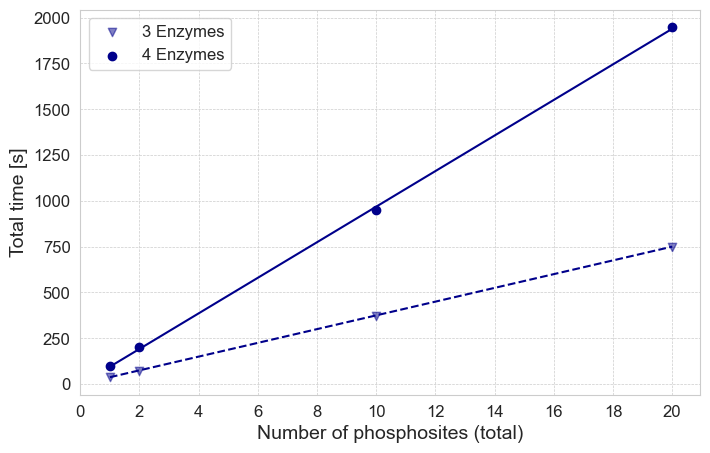

In [27]:
def plot_multiple_time_lin_e(x_dict, y_data_dict, x_label, y_label, x_predict, title = 'Linear Fit'):
    
    # Define the linear function you want to fit
    def linear_func(x, a, b):
        return a * x + b

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5), dpi=100)  # Create a larger figure for better visualization
    
    custom_labels = []
    custom_handles = []
    
    for i, (key, x_data) in enumerate(x_dict.items()):

        # Define color based on key
        if "4" in key:
            linestyle = '-'
            alpha = 1
            marker='o'
        elif "3" in key:
            linestyle = '--'
            alpha = 0.5
            marker='v'

        y_data = y_data_dict[key]
        # Fit the linear function to the data
        params, covariance = curve_fit(linear_func, x_data, y_data)

        # Parameters of the fitted linear function
        a_fit, b_fit = params

        # Predict y-value
        y_predict = linear_func(x_predict, a_fit, b_fit)

        # Calculate R^2
        residuals = y_data - linear_func(x_data, a_fit, b_fit)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Plot the original data
        plt.scatter(x_data, y_data, label=f'{key}', color='darkblue', alpha=alpha, marker=marker)
        x_range = np.linspace(min(x_data), max(x_data), 100)
        line, = plt.plot(x_range, linear_func(x_range, a_fit, b_fit), color='darkblue', linestyle=linestyle, linewidth=1.5)  # Get line for color

        # Collect custom labels and handles
        custom_labels.append(f'R^2={r_squared:.4f}')
        custom_handles.append(line)

        print(f'Predicted y-value for x = {x_predict}: {y_predict}s = {y_predict/60}min = {y_predict/3600}h')

    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Create the first legend for the line labels
    legend1 = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    # Add the first legend manually to the current Axes
    # plt.gca().add_artist(legend1)
    # Create the second legend for the custom labels
    # plt.legend(custom_handles, custom_labels, loc='upper left', bbox_to_anchor=(0, 0.84), fontsize=12)

    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.xticks(np.arange(0, max(x_data) + 1, 2.0))

    plt.show()

plot_multiple_time_lin_e(x_features_e, y_time_e, 'Number of phosphosites (total)', 'Total time [s]', 10000, title=None)